In [68]:
import pandas as pd

stock_data_path = r"C:\Users\L0145\Downloads\stock_data.csv"
industry_data_path = r"C:\Users\L0145\Downloads\tickers_industry_data.csv"

stock_data = pd.read_csv(stock_data_path, header=[0, 1], index_col=0)
industry_data = pd.read_csv(industry_data_path)

print(stock_data.head())
print(industry_data.head())

Ticker           AMZN                                             PATH       \
Price            Open       High        Low      Close     Volume Open High   
Date                                                                          
2019-01-02  73.260002  77.667999  73.046501  76.956497  159662000  NaN  NaN   
2019-01-03  76.000504  76.900002  74.855499  75.014000  139512000  NaN  NaN   
2019-01-04  76.500000  79.699997  75.915497  78.769501  183652000  NaN  NaN   
2019-01-07  80.115501  81.727997  79.459503  81.475502  159864000  NaN  NaN   
2019-01-08  83.234497  83.830498  80.830498  82.829002  177628000  NaN  NaN   

Ticker                       ...       PARA                                   \
Price      Low Close Volume  ...       Open       High        Low      Close   
Date                         ...                                               
2019-01-02 NaN   NaN    NaN  ...  37.383789  39.209270  37.143820  39.132137   
2019-01-03 NaN   NaN    NaN  ...  38.849324  40

In [69]:
# Double check
print(stock_data_reset.columns)
print(stock_data_reset.head())

MultiIndex([('Date',       ''),
            ('AMZN',   'Open'),
            ('AMZN',   'High'),
            ('AMZN',    'Low'),
            ('AMZN',  'Close'),
            ('AMZN', 'Volume'),
            ('PATH',   'Open'),
            ('PATH',   'High'),
            ('PATH',    'Low'),
            ('PATH',  'Close'),
            ...
            ('PARA',   'Open'),
            ('PARA',   'High'),
            ('PARA',    'Low'),
            ('PARA',  'Close'),
            ('PARA', 'Volume'),
            ( 'BCS',   'Open'),
            ( 'BCS',   'High'),
            ( 'BCS',    'Low'),
            ( 'BCS',  'Close'),
            ( 'BCS', 'Volume')],
           names=['Ticker', 'Price'], length=1764)
Ticker        Date       AMZN                                              \
Price                    Open       High        Low      Close     Volume   
0       2019-01-02  73.260002  77.667999  73.046501  76.956497  159662000   
1       2019-01-03  76.000504  76.900002  74.855499  75.01400

In [70]:
# Fix column names (flatten multi-index)
stock_data.columns = ['_'.join(col).strip() for col in stock_data.columns]
stock_data.reset_index(inplace=True)
stock_data.rename(columns={"Date_": "Date"}, inplace=True)

# Convert from wide to long format
stock_data_long = stock_data.melt(id_vars=["Date"], var_name="Ticker_Metric", value_name="Value")

# Split 'Ticker_Metric' into separate 'Ticker' and 'Metric' columns
stock_data_long[["Ticker", "Metric"]] = stock_data_long["Ticker_Metric"].str.rsplit("_", n=1, expand=True)

stock_data_long.drop(columns=["Ticker_Metric"], inplace=True)

# Pivot so that Open, High, Low, Close, and Volume are columns
stock_data_long = stock_data_long.pivot(index=["Date", "Ticker"], columns="Metric", values="Value").reset_index()

# Merge with industry data
stock_data_merged = stock_data_long.merge(industry_data, on="Ticker", how="left")

print(stock_data_merged.head())

         Date Ticker  Adj Close      Close       High        Low       Open  \
0  2019-01-02     AA        NaN  25.303432  25.888768  24.570558  25.028605   
1  2019-01-02    AAL        NaN  31.963158  32.130454  30.555912  30.959388   
2  2019-01-02   AAPL        NaN  37.667175  37.889001  36.787034  36.944458   
3  2019-01-02   ABBV        NaN  67.518402  69.054458  66.905489  69.039321   
4  2019-01-02   ABEV        NaN   3.439978   3.472740   3.251598   3.276170   

        Volume                      Industry  
0    3067000.0                      Aluminum  
1    5229500.0                      Airlines  
2  148158800.0          Consumer Electronics  
3    6908400.0  Drug Manufacturers - General  
4   20573600.0           Beverages - Brewers  


In [71]:
import numpy as np

stock_data_merged["Date"] = pd.to_datetime(stock_data_merged["Date"])

stock_data_merged.sort_values(by=["Ticker", "Date"], inplace=True)
stock_data_merged["Return"] = stock_data_merged.groupby("Ticker")["Close"].pct_change()

# Compute rolling 30-day volatility
stock_data_merged["Volatility"] = (
    stock_data_merged.groupby("Ticker")["Return"].rolling(window=30).std().reset_index(level=0, drop=True)
)

covid_cutoff = pd.Timestamp("2020-03-11")
stock_data_merged["Period"] = np.where(stock_data_merged["Date"] < covid_cutoff, "Pre-COVID", "Post-COVID")

# Aggregate sector-wise statistics
sector_analysis = stock_data_merged.groupby(["Industry", "Period"]).agg(
    Avg_Return=("Return", "mean"),
    Avg_Volatility=("Volatility", "mean")
).reset_index()

print(sector_analysis.head())

C:\Users\L0145\AppData\Local\Temp\ipykernel_2828\1755420765.py:7: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  stock_data_merged["Return"] = stock_data_merged.groupby("Ticker")["Close"].pct_change()


               Industry      Period  Avg_Return  Avg_Volatility
0  Advertising Agencies  Post-COVID    0.000648        0.019326
1  Advertising Agencies   Pre-COVID   -0.000054        0.012656
2   Aerospace & Defense  Post-COVID    0.001081        0.034008
3   Aerospace & Defense   Pre-COVID    0.000019        0.021397
4              Airlines  Post-COVID    0.000587        0.029239


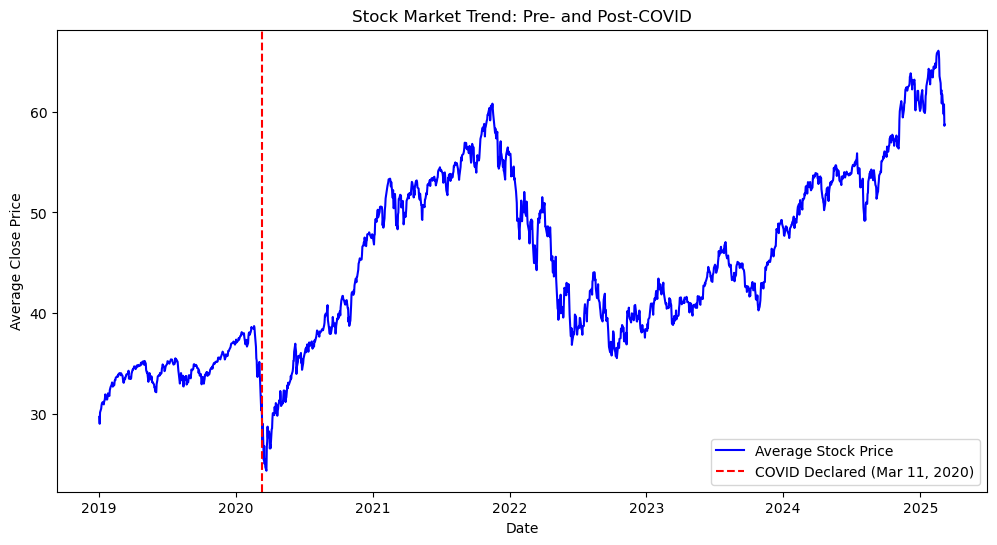

In [59]:
import matplotlib.pyplot as plt

market_trend = stock_data_merged.groupby("Date")["Close"].mean()

plt.figure(figsize=(12, 6))
plt.plot(market_trend.index, market_trend, label="Average Stock Price", color="blue")
plt.axvline(pd.Timestamp("2020-03-11"), color="red", linestyle="--", label="COVID Declared (Mar 11, 2020)")
plt.xlabel("Date")
plt.ylabel("Average Close Price")
plt.title("Stock Market Trend: Pre- and Post-COVID")
plt.legend()
plt.show()

<Figure size 1400x600 with 0 Axes>

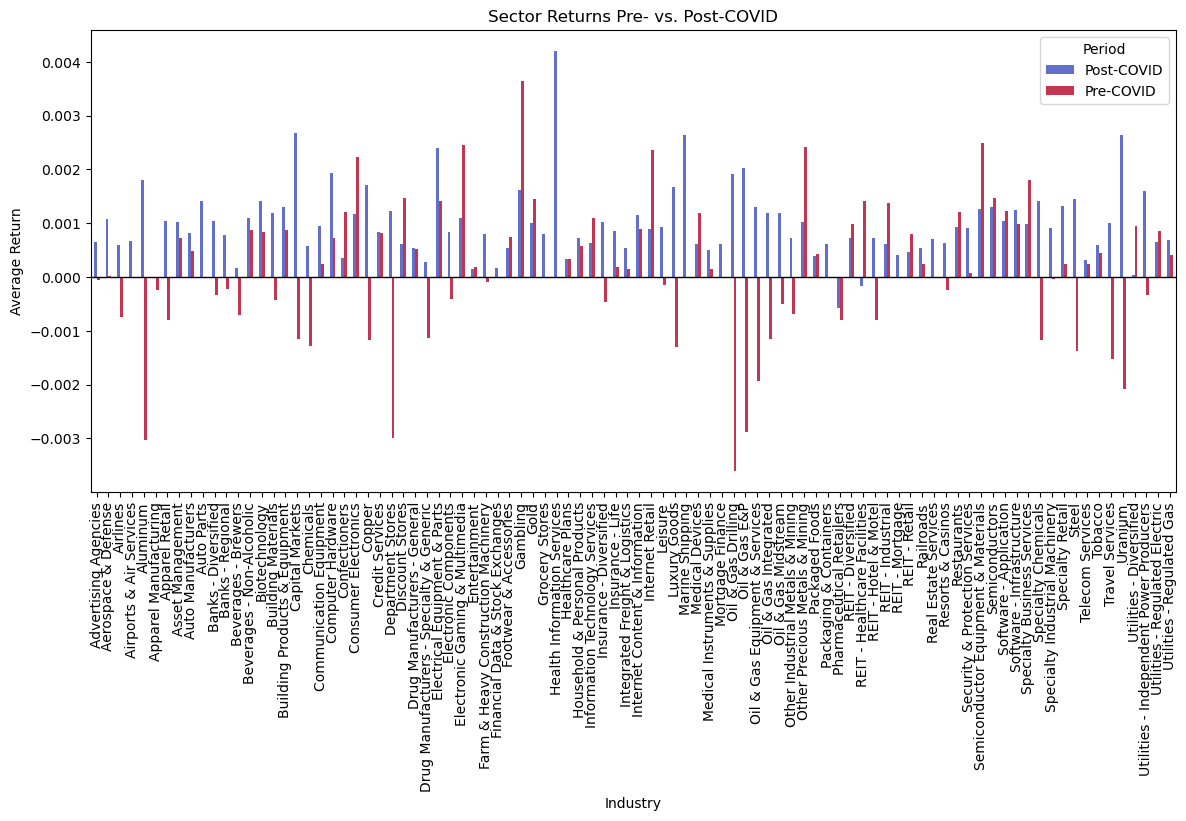

In [72]:
import seaborn as sns

sector_pivot = sector_analysis.pivot(index="Industry", columns="Period", values="Avg_Return")

plt.figure(figsize=(14, 6))
sector_pivot.plot(kind="bar", figsize=(14, 6), colormap="coolwarm", alpha=0.8)
plt.axhline(0, color="black", linewidth=1)  # Add a reference line at y=0
plt.xlabel("Industry")
plt.ylabel("Average Return")
plt.title("Sector Returns Pre- vs. Post-COVID")
plt.legend(title="Period")
plt.xticks(rotation=90)
plt.show()

In [61]:
print(stock_data_merged["Industry"].unique())

# Adjust selected sectors to match actual labels
selected_sectors = ["Software - Application", "Drug Manufacturers - General", "Oil & Gas E&P"]

['Aluminum' 'Airlines' 'Consumer Electronics'
 'Drug Manufacturers - General' 'Beverages - Brewers' 'Travel Services'
 'Medical Devices' 'Aerospace & Defense' 'Grocery Stores'
 'Security & Protection Services' 'Insurance - Diversified'
 'Apparel Retail' 'Utilities - Diversified' 'Software - Infrastructure'
 'REIT - Mortgage' 'Semiconductors' 'Software - Application'
 'Specialty Chemicals' 'Semiconductor Equipment & Materials'
 'Packaging & Containers' 'Internet Retail' 'Computer Hardware'
 'Oil & Gas E&P' 'REIT - Hotel & Motel' 'Asset Management' 'Leisure'
 'Communication Equipment' 'Information Technology Services'
 'Medical Instruments & Supplies' 'Banks - Diversified' 'Banks - Regional'
 'Specialty Retail' 'Electrical Equipment & Parts' 'Real Estate Services'
 'Electronic Gaming & Multimedia' 'Oil & Gas Equipment & Services'
 'Oil & Gas Integrated' 'Gold' 'Tobacco' 'Internet Content & Information'
 'Packaged Foods' 'Building Products & Equipment'
 'Beverages - Non-Alcoholic' 'Steel'

In [62]:
sector_volatility = stock_data_merged[stock_data_merged["Industry"].isin(selected_sectors)]
print("Sectors in filtered data:", sector_volatility["Industry"].unique())
print("Number of rows:", len(sector_volatility))

Sectors in filtered data: ['Drug Manufacturers - General' 'Software - Application' 'Oil & Gas E&P']
Number of rows: 59052


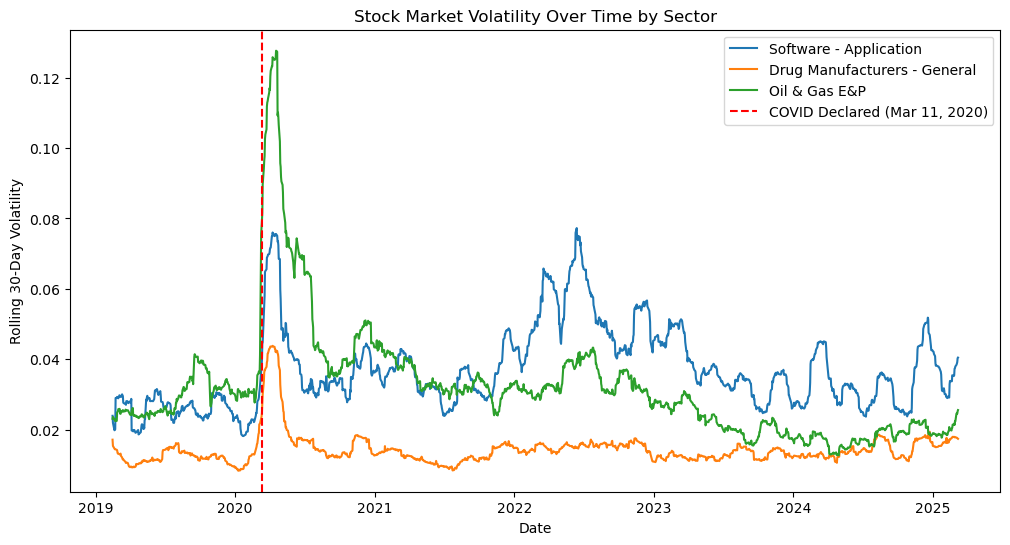

In [63]:
plt.figure(figsize=(12, 6))
for sector in selected_sectors:
    sector_data = sector_volatility[sector_volatility["Industry"] == sector].dropna(subset=["Volatility"])
    if not sector_data.empty:
        avg_volatility = sector_data.groupby("Date")["Volatility"].mean()
        plt.plot(avg_volatility.index, avg_volatility, label=sector)
    else:
        print(f"No data for sector: {sector}")

plt.axvline(pd.Timestamp("2020-03-11"), color="red", linestyle="--", label="COVID Declared (Mar 11, 2020)")
plt.xlabel("Date")
plt.ylabel("Rolling 30-Day Volatility")
plt.title("Stock Market Volatility Over Time by Sector")
plt.legend()
plt.show()

In [64]:
stock_data_merged["Date"] = pd.to_datetime(stock_data_merged["Date"])

market_trend = stock_data_merged.groupby("Date")["Close"].mean().reset_index()

peak_date = market_trend[market_trend["Date"] < "2020-03-11"]["Close"].idxmax()
trough_date = market_trend["Close"].idxmin()

peak_price = market_trend.loc[peak_date, "Close"]
trough_price = market_trend.loc[trough_date, "Close"]

percentage_decline = ((peak_price - trough_price) / peak_price) * 100
print(f"Market Decline: {percentage_decline:.2f}%")

Market Decline: 37.08%


Period                          Post-COVID  Pre-COVID  Absolute_Change  \
Industry                                                                 
Oil & Gas Drilling                0.001909  -0.003605         0.005514   
Oil & Gas E&P                     0.002025  -0.002872         0.004898   
Aluminum                          0.001799  -0.003035         0.004833   
Uranium                           0.002642  -0.002075         0.004716   
Department Stores                 0.001231  -0.003001         0.004231   
Capital Markets                   0.002673  -0.001144         0.003816   
Oil & Gas Equipment & Services    0.001296  -0.001934         0.003229   
Luxury Goods                      0.001681  -0.001299         0.002981   
Copper                            0.001714  -0.001172         0.002885   
Steel                             0.001445  -0.001371         0.002817   

Period                          Relative_Change  
Industry                                         
Oil & Gas D

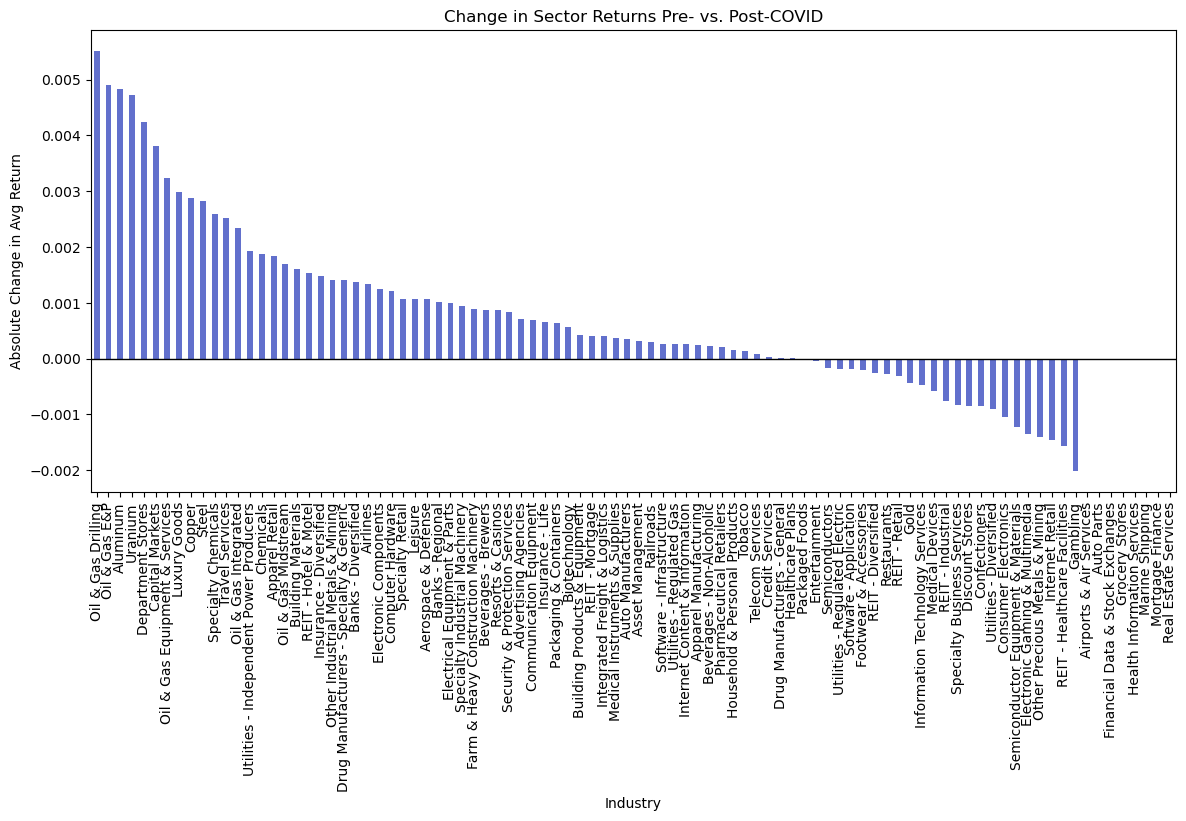

In [73]:
sector_pivot["Absolute_Change"] = sector_pivot["Post-COVID"] - sector_pivot["Pre-COVID"]
sector_pivot["Relative_Change"] = (sector_pivot["Absolute_Change"] / sector_pivot["Pre-COVID"].replace(0, np.nan)) * 100  # Avoid division by zero

sector_pivot_sorted = sector_pivot.sort_values(by="Absolute_Change", ascending=False)

print(sector_pivot_sorted.head(10))
print(sector_pivot_sorted.tail(10))

plt.figure(figsize=(14, 6))
sector_pivot_sorted["Absolute_Change"].plot(kind="bar", colormap="coolwarm", alpha=0.8)
plt.axhline(0, color="black", linewidth=1)  # Reference line at y=0
plt.xlabel("Industry")
plt.ylabel("Absolute Change in Avg Return")
plt.title("Change in Sector Returns Pre- vs. Post-COVID")
plt.xticks(rotation=90)
plt.show()
